**Analysis of metabolic dynamics during drought stress in Arabidopsis plants**

**DNB Analysis script**

First, load the libraries:

In [70]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
import statistics
from sklearn import preprocessing
import scipy.cluster.hierarchy as spc
import math
import matplotlib.pyplot as plt

*indices_for_clusters* is a function created for DNB Analysis.
This function calculates the SDin, PCCin and PCCout of the group of molecules than can be DNBs. 

In [77]:
def indices_for_clusters(cluster, currDNB, control, case, condit, genotype):
    """
    cluster: cluster number of the potential DNB (integer)
    currDNB: list of metabolites that are a potential DNB (list of strings)
    control: dataframe of control metabolomic data (pandas dataframe)
    case: dataframe of case metabolomic data (pandas dataframe)
    condit: condition under study (string)
    genotype: genotype under study (string)
    """
    res = []
    newcurr = case.loc[:,currDNB]
    controlcurr = control.loc[:,currDNB]

    if len(currDNB) > 1: #clusters with only one member (dominant group of molecules has only one member) are not allowed
        
        #Calculate SDin: standard deviation intra-cluster (dominant group of molecules)
        SD_clust = 0
        sd_n = 0
        for A2 in currDNB:
            SDt = statistics.stdev(newcurr.loc[:, A2])
            SD0 = statistics.stdev(controlcurr.loc[:, A2])
            SDnextt = abs(math.log10(SDt/SD0)) # normalize the SDt against t0
            sd_neg = math.log10(SDt/SD0) # we also save the SD without absolute value 
            SD_clust = SD_clust + SDnextt
            sd_n = sd_n + sd_neg

        SDin = SD_clust / len(currDNB)
        Sd = sd_n / len(currDNB)

        #Calculate PCCin: pearson correlation coefficient intra-cluster (dominant group of molecules)
        SumIntraCorr = 0
        yet = []
        for A3 in currDNB:
            for B1 in currDNB:
                pair = A3+"-"+B1
                pair_inv = B1+"-"+A3           
                if A3 != B1 and pair not in yet and pair_inv not in yet:
                    yet.append(pair)
                    yet.append(pair_inv)
                    first = newcurr.loc[:, A3]
                    second = newcurr.loc[:, B1]
                    pearsoncorr, _ = pearsonr(first, second)  
                    SumIntraCorr = SumIntraCorr + abs(pearsoncorr)
        PCCintra = SumIntraCorr/(len(currDNB)*(len(currDNB)-1))

        #Calculate PCCout: pearson correlation coefficient inter-cluster (dominant group of molecules with other molecules)
        interDNB = list(case.columns) #first, extract all metabolite names
        for j in interDNB:
            if j in currDNB: #if the metabolite is in the current set of metabolites under study (DNB), remove it
                interDNB.remove(j)
        interclust = case.loc[:,interDNB]
        SumInterCorr = 0
        yet = []
        for A4 in currDNB:
            for B2 in interDNB:
                pair = A4+"-"+B2
                pair_inv = B2+"-"+A4           
                if A4 != B2 and pair not in yet and pair_inv not in yet:
                    yet.append(pair)
                    yet.append(pair_inv)
                    first = newcurr.loc[:, A4]
                    second = interclust.loc[:, B2]
                    pearsoncorr, _ = pearsonr(first, second)
                    SumInterCorr = SumInterCorr + abs(pearsoncorr)
        PCCinter = SumInterCorr / (len(currDNB)*((len(currDNB)+len(interDNB))-len(currDNB)))

        CI = (SDin * PCCintra) / PCCinter

        res.append([genotype, condit, cluster, currDNB, SDin, PCCintra, PCCinter, CI, Sd])

    else:
        res.append([genotype, condit, cluster, currDNB, 0, 0, 0, 0, 0]) 

    return(res)

After defining the function, the dataset has to be loaded. 
In this case, the DNB analysis takes as input the normalized metabolite abundances (Supplementary Table 2) as input.

In [73]:
datasetname = "Supplementary_table2.csv"  #Name of the normalized dataset file and extension (.csv here) 
dataset = pd.read_csv(datasetname, sep = ",")

REMEMBER: This is an example for the DNB analysis of the BRL3ox genotype in roots. 

Manually, select the tissue and genotype for the DNB analysis as follows:

In [22]:
tissue = dataset.loc[(dataset["Tissue"] == "root")] #EDIT: tissue under study ("root" or "shoot" here)
genotype = "35S:BRL3-GFP" #EDIT: ID of the genotype under study ("Col-0WT", "35S:BRL3-GFP" or "bri1-301bak1brl1brl3" here)

Separate the metadata and metabolites to keep only the metadata that is need for the DNB analysis. 

In [ ]:
metadata = tissue.loc[:,["Tissue", "Genotype", "Condition"]] 
metabolites = tissue.iloc[:,6:]

In [ ]:
metadata.head()

In [ ]:
metabolites.head()

Finally, merge metadata and metabolites in one dataframe to start the analysis. 

In [ ]:
tissue = pd.concat([metadata, metabolites], axis = 1)
tissue.head()

**DNB analysis**

First, To determine the optimal number of clusters: 

    1) Calculate the best CIs for 2 to 15 clusters in a for loop. 
    
    2) Plot the CI value obained by each cluster and select the number of clusters which obtain the highest CI.

In [78]:
cluster = []
CIs = []
genot = tissue.loc[(tissue["Genotype"] == genotype)]

for numclust in range(2,16):
    control = genot.loc[(genot["Condition"] == "0")] #control is the sub-dataset of samples at time 0
    case = genot.loc[(genot["Condition"].str.contains("D"))] #case is the sub-dataset of samples under drought stress (D)
    metab = list(control.columns)
    
    df = genot.loc[(genot["Condition"].str.contains("D") | (genot["Condition"] == "0"))]
            
    #calculate distances and clusters based on correlation
    corr = df.iloc[:,3:].corr().abs().values #avoid string data columns with [:,3:]
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, "complete") # complete method for hierarchical clustering 
    hcModel = spc.fcluster(linkage, round(numclust), "maxclust") # select the maximum number of cluster allowed
    labels = [df.iloc[:,3:].columns.tolist()[i] for i in list((np.argsort(hcModel)))]
    cluster = []
    # associate metabolites to clusters
    for i in range(len(hcModel)):
        cluster.append([genotype, hcModel[i], labels[i]])
    clusters = pd.DataFrame(cluster, columns=["Genotype", "Cluster", "Metabolite"])

    #calculate the signals for each cluster and for each time-point with the *indices_for_clusters* function
    param=[]
    n_clusters = list(set(clusters.loc[:,"Cluster"]))
    for c in range(1, max(n_clusters)+1): #for each cluster
        currDNB = list(clusters.loc[clusters["Cluster"] == c].iloc[:,2])
        for period in range(1,7): #for each time point
            p = str(period)+"D"
            data_period = genot.loc[(genot["Condition"].str.contains(p))].iloc[:,3:]
            param.append(indices_for_clusters(c, currDNB, control, data_period, p, genotype))


    #save all in a single dataframe
    drought = pd.DataFrame(param[0], columns=["genotype", "period", "cluster", "DNB", "SD", "PCCintra", "PCCinter", "CI", "SDnonabs"]) 
    for j in range(1,len(param)):
            d_2 = pd.DataFrame(param[j], columns=["genotype", "period", "cluster", "DNB", "SD", "PCCintra", "PCCinter", "CI", "SDnonabs"])
            drought = pd.concat([drought, d_2], ignore_index=True)

    #sort the potential DNBs by their CI and select the time-point associated to the highest CI for each cluster as a potential critical point.
    extracted = pd.DataFrame(columns = ["genotype", "period", "cluster", "DNB", "SD", "PCCintra", "PCCinter", "CI", "SDnonabs"])
    for clus in range(1, max(list(set(drought.loc[:,"cluster"])))+1):
        subsub = drought.loc[drought["cluster"] == clus]
        pot_subsub = subsub.loc[subsub["CI"] == max(list(subsub.loc[:,"CI"]))]
        extracted = pd.concat([extracted, pot_subsub])

    #sort the potentials DNBs and potential critical point (time-point selected before) by the CI value again to plot
    extractedsort = extracted.sort_values(by="CI", ascending=False)
    CIs.append([numclust, extractedsort.iloc[0,7]])


Plot the CIs obtained by each number of cluster tested and select the first value of number of cluster which has the highest value for CI. 

<AxesSubplot:xlabel='Number of clusters'>

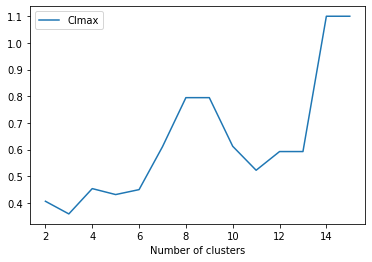

In [79]:
pd.DataFrame(CIs, columns = ["Number of clusters", "CImax"]).plot(x = "Number of clusters", y = "CImax")

Second, with the selected number of cluster, perform the clustering by the correlation values in time-point (t) and time-point 0 as before.

REMEMBER: In the following code chunk, *numclust* has to be modified to include the number of the cluster which has obtain the best CI (see the plot generated before).

In [80]:
cluster = []
numclust = 14 #EDIT: insert the number of cluster after plotting

genot = tissue.loc[(tissue["Genotype"] == genotype)]
control = genot.loc[(genot["Condition"] == "0")].iloc[:,3:]
case = genot.loc[(genot["Condition"].str.contains("D"))]
metab = list(control.columns)


In [81]:
#calculate distances and clusters based on correlation
corr = df.iloc[:,3:].corr().abs().values 
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, "complete")
hcModel = spc.fcluster(linkage, numclust, "maxclust")
labels = [df.iloc[:,3:].columns.tolist()[i] for i in list((np.argsort(hcModel)))]

# associate metabolites to clusters
for i in range(len(hcModel)):
    cluster.append([numclust, hcModel[i], labels[i]])
clusters = pd.DataFrame(cluster, columns=["Genotype", "Cluster", "Metabolite"])

In [ ]:
clusters.head()

Third, for each cluster and for each time-point, calculate SDin, PCCin, PCCout and CI with the function "indices_for_clusters".

In [83]:
param=[]
n_clusters = list(set(clusters.loc[:,"Cluster"]))
for c in range(1, max(n_clusters)+1):
    currDNB = list(clusters.loc[clusters["Cluster"] == c].iloc[:,2])
    for period in range(1,7):
        p = str(period)+"D"
        data_period = genot.loc[(genot["Condition"].str.contains(p))].iloc[:,3:]
        param.append(indices_for_clusters(c, currDNB, control, data_period, p, genotype))

drought = pd.DataFrame(param[0], columns=["genotype", "period", "cluster", "DNB", "SDin", "PCCintra", "PCCinter", "CI", "SDnonabs"])
for j in range(1,len(param)):
        d_2 = pd.DataFrame(param[j], columns=["genotype", "period", "cluster", "DNB", "SDin", "PCCintra", "PCCinter", "CI", "SDnonabs"])
        drought = pd.concat([drought, d_2], ignore_index=True)

Save in a csv file the pandas dataframe with the results for all the clusters.

REMEMBER: Edit the file name depending the tissue and genotype under study.

In [ ]:
drought.to_csv("Root"+genotype+"Results.csv", index=False)

Forth, time-points of each cluster that have the highest CI value are potential critical point.

In [ ]:
extracted = pd.DataFrame(columns = ["genotype", "period", "cluster", "DNB", "SDin", "PCCintra", "PCCinter", "CI", "SDnonabs"])
for clus in range(1, max(list(set(drought.loc[:,"cluster"])))+1):
    subsub = drought.loc[drought["cluster"] == clus]
    pot_subsub = subsub.loc[subsub["CI"] == max(list(subsub.loc[:,"CI"]))]
    extracted = pd.concat([extracted, pot_subsub])

extracted.sort_values(by="CI", ascending=False)

Fifth, keep as the final DNB the cluster that show the highest value of CI. 

In [ ]:
sort = extracted.sort_values(by="CI", ascending=False)
final = pd.DataFrame(sort.iloc[0, :])

sub_cluster = drought.loc[(drought["cluster"] == int(final.iloc[2,:]))]

print("CIs are: ", list(sub_cluster.loc[:,"CI"]))
print("SDins are: ", list(sub_cluster.loc[:,"SDin"]))
print("PCCintras are: ", list(sub_cluster.loc[:,"PCCintra"]))
print("PCCinters are: ", list(sub_cluster.loc[:,"PCCinter"]))

Finally, create the dot plots for SDs, PCCs and CI of the DNB in all time-points. 

In [ ]:
sub_cluster.loc[:,["period", "CI"]].plot(x="period", y="CI")
#plt.savefig((str(genotype)+"_CI.png"))

sub_cluster.loc[:,["period", "SDin"]].plot(x="period", y="SDin")
#plt.savefig((str(genotype)+"_SDin.png"))

sub_cluster.loc[:,["period", "PCCintra"]].plot(x="period", y="PCCintra")
#plt.savefig((str(genotype)+"_PCCintra.png"))

sub_cluster.loc[:,["period", "PCCinter"]].plot(x="period", y="PCCinter")
#plt.savefig((str(genotype)+"_PCCinter.png"))

Save the CIs of all genotypes for root and shoot tissues separatedly in a csv file.

In [ ]:
dfCIs = {'Genotype': list(sub_cluster.loc[:,"genotype"]), 'DNB': list(sub_cluster.loc[:,"DNB"]), 'CI': list(sub_cluster.loc[:,"CI"])}
dfCIs = pd.DataFrame.from_dict(dfCIs)

In [85]:
dfCIs.to_csv("Root"+genotype+"DNBCIs.csv", index=False) #EDIT: tissue under study ("root" or "shoot" here)

If you prefer to append the CIs of other genotypes and tissues to an existing csv file, run the following code only for the first tissue and genotype to create the file.

In [ ]:
from csv import writer

dfCIs2 = {'Genotype': list(sub_cluster.loc[:,"genotype"]), 'DNB': list(sub_cluster.loc[:,"DNB"]), 'CI': list(sub_cluster.loc[:,"CI"])}
dfCIs2 = pd.DataFrame.from_dict(dfCIs2)
dfCIs2.to_csv("AllDNBCIs.csv", index=False) #EDIT: tissue under study ("root" or "shoot" here)

Then, run the following code for aapend the CIs for the rest genotypes and tissues. 

In [64]:
with open("RootDNBCIs.csv", 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        for r in range(dfCIs2.shape[0]):
            csv_writer.writerow(dfCIs2.iloc[r,:])
        